# **** PUBG Finish Placement ****

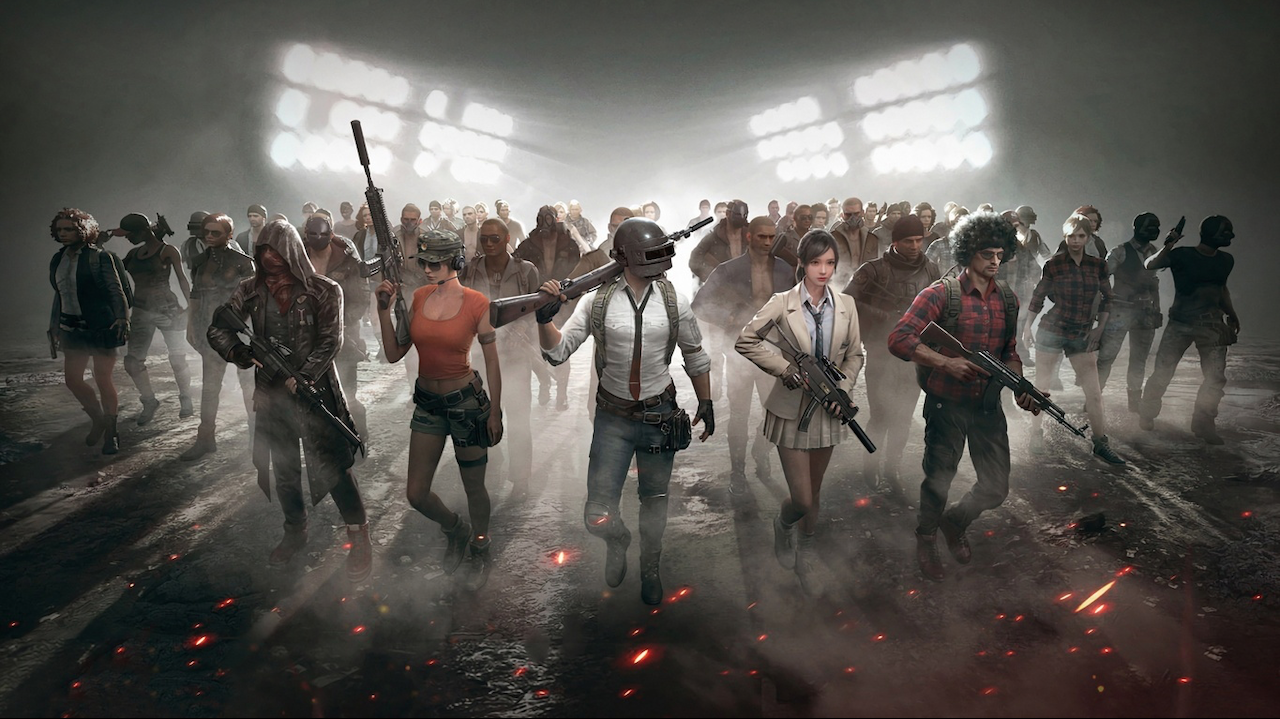

## Purpose

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place). Use the data dictionary for more information regarding the data.

|Feature|Type|Description|
|---|---|---|
|DBNOs|int|Number of enemy players knocked|
|assists|int|Number of enemy players this player damaged that were killed by teammates| 
|boosts|int|Number of boost items used|
|damageDealt|float|Total damage dealt. Note: Self inflicted damage is subtracted|
|headshotKills|int|Number of enemy players killed with headshots|
|heals|int|Number of healing items used|
|Id|object|Player’s Id|
|killPlace|int|Ranking in match of number of enemy players killed|
|killPoints|int|Kills-based external ranking of player. If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”|
|killStreaks|int|Max number of enemy players killed in a short amount of time|
|kills|int|Number of enemy players killed|
|longestKill|float|Longest distance between player & player killed at time of death|
|matchDuration|int|Duration of match in seconds|
|matchId|object|ID to identify match. There are no matches that are in both the training and testing set| 
|matchType|object|Identifies standard game modes: “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp” & “squad-fpp”; other modes are from customs|
|rankPoints|int|Elo-like ranking of player. This ranking is inconsistent & is being deprecated in the next version. Value of -1 takes place of “None”|
|revives|int|Number of enemy players killed with headshots|
|rideDistance|float|Number of healing items used|
|roadKills|int|Number of kills while in a vehicle|
|swimDistance|float|Total distance traveled by swimming measured in meters|
|teamKills|int|Number of times this player killed a teammate|
|vehicleDestroys|int|Number of vehicles destroyed|
|walkDistance|float|Total distance traveled on foot measured in meters|
|weaponsAcquired|int|Number of weapons picked up|
|winPoints|int|Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”|
|groupId|object|ID to identify a group within a match. If the same group of players plays in different matches, they'll have a different groupId each time|
|numGroups|int|Number of groups we have data for in the match|
|maxPlace|int|Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements|
|winPlacePerc|float|The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match|

## Loading in the Data

In [1]:
import pandas as pd # Imports Pandas
import numpy as np  # Imports Numpy
import seaborn as sns # Imports Seaborn
import matplotlib.pyplot as plt # Imports MatPlotLib
from sklearn.model_selection import train_test_split, GridSearchCV # Imports Gridsearch, train/test split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV # Imports Regression Metrics
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

%matplotlib inline

In [2]:
pubg_train = pd.read_csv('./data/pubg_train.csv')
pubg_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [3]:
pubg_test = pd.read_csv('./data/pubg_test.csv')
pubg_test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


## Cleaning

In [4]:
# Here is a function for basic exploratory data analysis:
def eda(dataframe):
    # Replace any blank spaces w/ a underscore.
    dataframe.columns = dataframe.columns.str.replace(" ", "_")
    # Checks for the null values.
    print("missing values: {}".format(dataframe.isnull().sum().sum()))
    # Checks the data frame range size.
    print("dataframe index: {}".format(dataframe.index))
    # Checks for data types of the columns within the data frame.
    print("dataframe types: {}".format(dataframe.dtypes))
    # Checks the shape of the data frame.
    print("dataframe shape: {}".format(dataframe.shape))
    # Gives us any statistical information of the data frame.
    print("dataframe describe: {}".format(dataframe.describe()))
    # Gives us the duplicated data of the data frame. 
    print("dataframe duplicates: {}".format(dataframe[dataframe.duplicated()].sum()))
    
    # A for loop that does this for every single column & their values within our data frame giving us all 
        # unique values.
    for item in dataframe:
        print(item)
        print(dataframe[item].nunique())

# Let's apply this function to our entire data frame.
eda(pubg_train)

missing values: 1
dataframe index: RangeIndex(start=0, stop=4446966, step=1)
dataframe types: Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object
dataframe shape: (4446966, 29)
dataframe describe:             assists        boosts   damageDealt         DB

In [5]:
# Here is a function for basic exploratory data analysis:
def eda(dataframe):
    # Replace any blank spaces w/ a underscore.
    dataframe.columns = dataframe.columns.str.replace(" ", "_")
    # Checks for the null values.
    print("missing values: {}".format(dataframe.isnull().sum().sum()))
    # Checks the data frame range size.
    print("dataframe index: {}".format(dataframe.index))
    # Checks for data types of the columns within the data frame.
    print("dataframe types: {}".format(dataframe.dtypes))
    # Checks the shape of the data frame.
    print("dataframe shape: {}".format(dataframe.shape))
    # Gives us any statistical information of the data frame.
    print("dataframe describe: {}".format(dataframe.describe()))
    # Gives us the duplicated data of the data frame. 
    print("dataframe duplicates: {}".format(dataframe[dataframe.duplicated()].sum()))
    
    # A for loop that does this for every single column & their values within our data frame giving us all 
        # unique values.
    for item in dataframe:
        print(item)
        print(dataframe[item].nunique())

# Let's apply this function to our entire data frame.
eda(pubg_test)

missing values: 0
dataframe index: RangeIndex(start=0, stop=1934174, step=1)
dataframe types: Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
dtype: object
dataframe shape: (1934174, 28)
dataframe describe:             assists        boosts   damageDealt         DBNOs  headshotKills  \
count

In [6]:
# Here's a function to convert NaN's in a specific column in the data set to 0.0 for floats.
# Just pass in the entire data frame & specify a specific column w/ a float NaN.
def convert_float_nan(data):
    return data.replace(np.nan, 0.0, inplace = True)
convert_float_nan(pubg_train["winPlacePerc"])

In [7]:
pubg_train['damageDealt'] = pubg_train['damageDealt'].astype(int)
pubg_train['longestKill'] = pubg_train['longestKill'].astype(int)
pubg_train['rideDistance'] = pubg_train['rideDistance'].astype(int)
pubg_train['swimDistance'] = pubg_train['swimDistance'].astype(int)
pubg_train['walkDistance'] = pubg_train['walkDistance'].astype(int)
pubg_train['winPlacePerc'] = pubg_train['winPlacePerc'].astype(int)

pubg_test['damageDealt'] = pubg_test['damageDealt'].astype(int)
pubg_test['longestKill'] = pubg_test['longestKill'].astype(int)
pubg_test['rideDistance'] = pubg_test['rideDistance'].astype(int)
pubg_test['swimDistance'] = pubg_test['swimDistance'].astype(int)
pubg_test['walkDistance'] = pubg_test['walkDistance'].astype(int)

## Exploratory Data Analysis

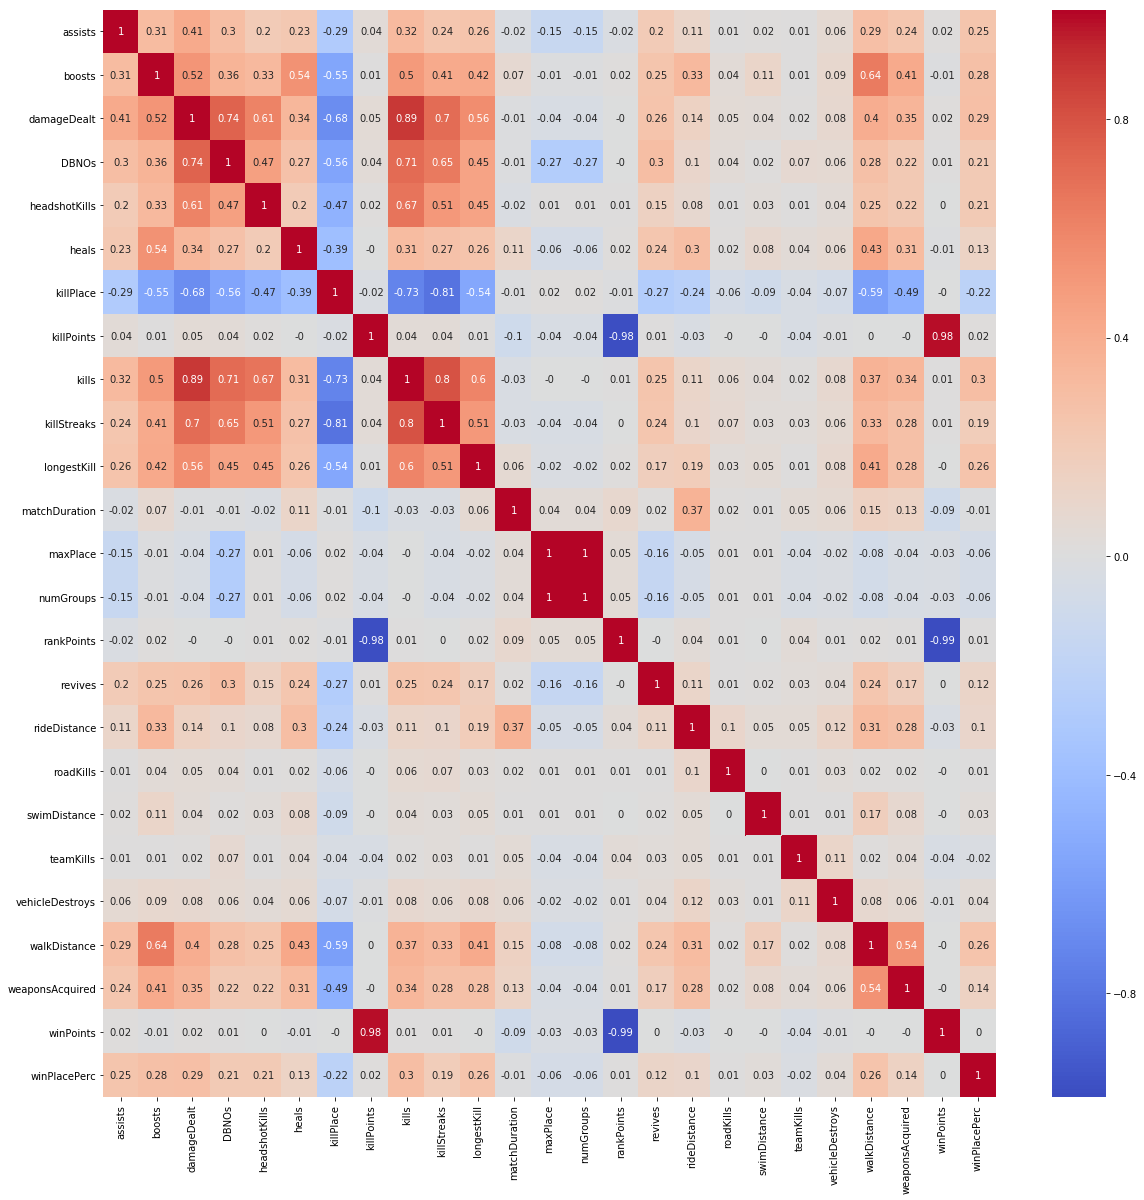

In [8]:
# Let's create a heatmap of the entire data frame.
# Not very pleasing to the eye, right?
plt.figure(figsize = (20,20))
sns.heatmap(np.round(pubg_train.corr(), 2), annot = True, cmap = 'coolwarm')

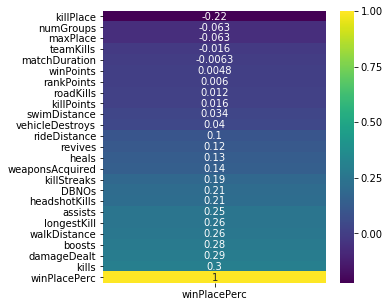

In [9]:
# Let's make a simple heat map on what column we're trying to predict to see correlations.
plt.figure(figsize = (5,5))
sns.heatmap(np.round(pubg_train.corr()[['winPlacePerc']].sort_values('winPlacePerc'), 30), annot = True, cmap = 'viridis')

In [10]:
# Let's view the largest negative correlated columns to our "winPlacePerc" column.
largest_neg_corr_list = pubg_train.corr()[['winPlacePerc']].sort_values('winPlacePerc').head(5).T.columns
largest_neg_corr_list

Index(['killPlace', 'numGroups', 'maxPlace', 'teamKills', 'matchDuration'], dtype='object')

In [11]:
# Let's view the largest positive correlated columns to our "winPlacePerc" column.
largest_pos_corr_list = pubg_train.corr()[['winPlacePerc']].sort_values('winPlacePerc').tail(5).T.columns.drop('winPlacePerc')
largest_pos_corr_list

Index(['walkDistance', 'boosts', 'damageDealt', 'kills'], dtype='object')

## Model Prep

In [12]:
# Here we can feature load our best correlated variables.
# Our y-variable is what we want to predict.
X = pubg_train[['killPlace', 'matchDuration', 'winPoints', 'killPoints', 'rankPoints', 'damageDealt', 'weaponsAcquired', 'boosts', 'walkDistance']]
y = pubg_train['winPlacePerc']

# Let's train test split our data.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Scales our data.
# Feature scaling is a method used to normalize the range of independent variables or features of data. 
# In data processing, it is also known as data normalization.
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


## Modeling

##### Why a Logit Model?
Logistic regression is an alternative method to use other than the simpler Linear Regression. Logistic regression uses the concept of odds ratios to calculate the probability. This is defined as the ratio of the odds of an event happening to it not happening.

In [13]:
# A pipeline that instantiates a tuned Logistic Regression model.
pipe_cv = Pipeline([
    ('lr', LogisticRegression())
])
# Here are our parameters we've tuned.
params = {
    'lr__C':[1.0],
    'lr__penalty':["l1"]
}

# Our Logistic Regression Model ran through a Grid Search Object.
gs_lr = GridSearchCV(pipe_cv, param_grid = params, cv = 3)
gs_lr.fit(X_train, y_train)
gs_lr.score(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.9712106293310434

In [14]:
# Let's run our model on the test data.
gs_lr.score(X_test, y_test)

0.9711983535748402

In [15]:
# Give's us our best parameters.
gs_lr.best_params_

{'lr__C': 1.0, 'lr__penalty': 'l1'}

## Submission

In [16]:
ybar = pubg_train.winPlacePerc.mean()
ybar

0.0286876490623045

In [17]:
submission = pd.DataFrame(pubg_test.Id)
submission['winPlacePerc'] = ybar
submission.to_csv('./data/pubg_submission.csv')

In [18]:
pubg_train.to_csv('./data/pubg_train_cleaned.csv')
pubg_test.to_csv('./data/pubg_test_cleaned.csv')